# **General data preparation tutorial**


### Terjemahan : *Kevin Darmawan 1806148744*

Selamat datang di tutorial untuk persiapan data. Notebook ini ditujukan untuk pemula yang ingin mempelajari cara menyiapkan dataset untuk diproses menggunakan algoritma *machine learning*. Silakan clone catatan ini, mencoba kodenya dan kembangkan !

![](https://2s7gjr373w3x22jf92z99mgm5w-wpengine.netdna-ssl.com/wp-content/uploads/2016/07/shutterstock_data_prep_-faithie.jpg)

### Berikut adalah bahan belajar tambahan untuk mempelajari teknik yang digunakan dalam notebook ini :

[*Memperbaiki data yang hilang*](https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-1-dda69d4f88ca)  
[*Features engineering*](https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/)  
[*Fungsi hot-one Encode dalam machine learning ?*](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)  
[*Dummy variable trap*](https://www.algosome.com/articles/dummy-variable-trap-regression.html)  
[*Hot-one Encoding*](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding)  
[*Scaling & Normalisasi*](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e)  

## **Daftar Isi**

1. [**Memperbaiki data yang hilang**](#missing)
2. [**Features engineering**](#fe)
3. [**Menangani Fitur Kategorikal**](#catvar)
4. [**Feature scaling**](#scaler)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler

import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [7]:
# Path of datasets
titanic_df = pd.read_csv('input/train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## **1. Memperbaiki data yang hilang dan *outlier*** <a id="missing"></a>

Masalah pertama yaang akan dialami ketika mempersiapkan data untuk digunakan dalam algoritma ML adalah data yang hilang. Untuk sebagian besar dataset, terutama yang berbasis data *real* biasanya memiliki data yang hilang. Contohnya pada dataset Titanic berikut terdapat nilai yang hilang :

In [8]:
missing_values = draw_missing_data_table(titanic_df)
display(missing_values)
missing_values[['Percent']].iplot(kind='bar', xTitle='Features', yTitle='Percent of missing values', title='Percent missing data by feature')

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


### Jika ada fitur (sebuah kolom dalam dataset) yang tidak kehilangan banyak data, kita dapat mengisi nilai yang hilang tersebut dengan berbagai metode :

- Jika data yang hilang terlalu banyak (>60%), drop kolom tersebut karena tidak cocok dijadikan fitur :

      titanic_df.drop('Cabin', axis=1, inplace=True)
      
- Jika data yang hilang hanya sedikit (1-2%) silakan drop row yang memiliki nilai kosong (NaN) :

      titanic_df['Age'].dropna(inplace=True)

### Solusi yang lebih baik untuk memperbaiki nilai hilang berjumlah sedikit yaitu dengan mengobservasi case demi case dan menggantikan nilai yang hilang dengan membandingkan fitur lain dalam observasi ini dan mencari pola diantara keduanya untuk menebak nilai yang hilang.

- Cara agar data tidak hilang adalah dengan mengisi nilai yang hilang dengan mean atau median dari kolom tersebut. Untuk kolom yang memiliki outlier yang dapat merusak mean, gunakan teori median.

      titanic_df['Age'].fillna(titanic_df['Age'].mean(), 1, inplace=True)
      titanic_df['Age'].fillna(titanic_df['Age'].median(), 1, inplace=True)
      
Pilihan strategi mengisi nilai kosong bergantung pada dataset dan imajinasi anda! Berpikirlah kreatif dan pikirkan mengapa data tersebut hilang dan bagaimana cara mengisinya! Cobalah berbagai metode pengisian nilai dan perhatikan bagaimana masing-masing metode mempengaruhi performa dari model. Lanjut ke dataset titanic :

Ternyata hanya ada 2 nilai yang hilang dari kolom 'embarked'. Dibawah adalah distribusi nilai Embarked dikelompokkan berdasarkan tarif dan jenis kelamin, keduanya memiliki nilai "Embarked" yang hilang. Lihat kembali kedua sample data untuk memilih nilai yang paling sesuai berdasarkan nilai tarif dan jenis kelamin nya:

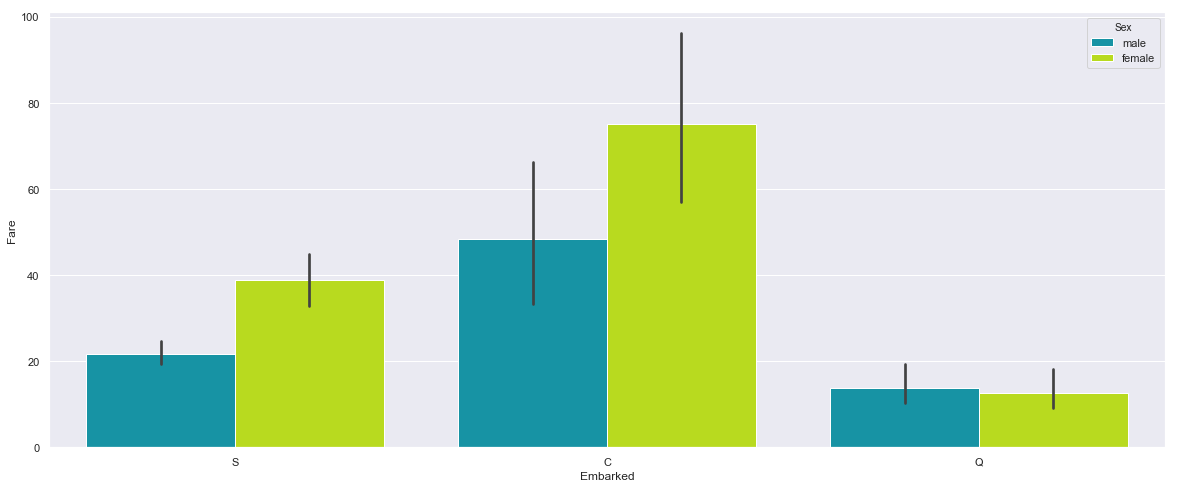

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [9]:
figure, axes = plt.subplots(1,1,figsize=(20, 8))
plot = sns.catplot(x="Embarked", y="Fare", hue="Sex", data=titanic_df, palette=('nipy_spectral'), kind="bar", ax=axes)
plt.close(plot.fig)
plt.show()
display(titanic_df[titanic_df['Embarked'].isnull()])

Kedua penumpang adalah perempuan yang membayar tarif tiket 80 dollar. Karena keduanya memiliki tiket dan kabin yang sama, kemungkinan mereka berangkat (embark) dari tempat yang sama. Melihat distribusi diatas, kemungkinan nilai 'embarked' untuk mereka adalah Cerbourg (C), mari kita coba...

In [10]:
titanic_df['Embarked'].fillna('C', inplace=True)

Untuk nilai umur terdapat 177 nilai yang hilang. Karena jumlahnya terlalu banyak untuk ditebak, maka kita gunakan median untuk nilai yang hilang. Mungkin ada cara yang lebih baik untuk masalah ini?

In [11]:
titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)

Terakhir adalah kolom 'cabin', kolom ini berguna untuk menemukan deck dari si penumpang. Kolom ini akan dipakai, namun nilai 'U' atau unknown harus diganti terlebih dahulu.

In [12]:
titanic_df['Cabin'].fillna('U', inplace=True)

In [13]:
draw_missing_data_table(titanic_df[['Cabin', 'Age', 'Embarked']])

,Total,Percent
Embarked,0,0.0
Age,0,0.0
Cabin,0,0.0


## **2. Features engineering** <a id="fe"></a>

Feature engineering adalah prosedur untuk membuat fitur baru dari fitur yang ada atau berdasarkan pemahaman data tersebut. Contohnya, huruf pertama dalam kolom 'cabin' menandakan deck tempat cabin tersebut berada (sumber = internet). Dari data tersebut kita dapat membuat kolom 'deck' dari fitur cabin tersebut. Selain itu kita bisa menambahkan kolom 'Title' yang berisi kata sapaan (Mr. dan Mrs.) dari setiap penumpang. Tujuan dari membuat fitur ini adalah untuk meningkatkan akurasi dari model ML, jadi buatlah fitur yang kira-kira akan membantu.

In [14]:
# Deck column from letter contained in cabin
titanic_df['Deck'] = titanic_df['Cabin'].str[:1]
titanic_df['Deck'] = titanic_df['Cabin'].map({cabin: p for p, cabin in enumerate(set(cab for cab in titanic_df['Cabin']))})

# Title column from title contained in name
titanic_df['Title'] = pd.Series((name.split('.')[0].split(',')[1].strip() for name in titanic_df['Name']), index=titanic_df.index)
titanic_df['Title'] = titanic_df['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic_df['Title'] = titanic_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs')

# Famillysize columns obtained by adding number of sibling and parch
titanic_df['FamillySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1
titanic_df['FamillySize'][titanic_df['FamillySize'].between(1, 5, inclusive=False)] = 2
titanic_df['FamillySize'][titanic_df['FamillySize']>5] = 3
titanic_df['FamillySize'] = titanic_df['FamillySize'].map({1: 'Alone', 2: 'Medium', 3: 'Large'})

# IsAlone and IsChild column, quite explicit
titanic_df['IsAlone'] = np.where(titanic_df['FamillySize']!=1, 0, 1)
titanic_df['IsChild'] = titanic_df['Age'] < 18
titanic_df['IsChild'] = titanic_df['IsChild'].astype(int)    

### Setelah fitur baru selesai dibentuk, drop kolom yang tidak terpakai dari dataset dan cek kembali head() dari dataset.

In [15]:
titanic_df = titanic_df.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], 1)    
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,FamillySize,IsAlone,IsChild
0,0,3,male,22.0,1,0,7.2500,S,130,Mr,Medium,0,0
1,1,1,female,38.0,1,0,71.2833,C,129,Mrs,Medium,0,0
2,1,3,female,26.0,0,0,7.9250,S,130,Miss,Alone,0,0
3,1,1,female,35.0,1,0,53.1000,S,64,Mrs,Medium,0,0
4,0,3,male,35.0,0,0,8.0500,S,130,Mr,Alone,0,0


## **3. Menangani Fitur Kategorikal** <a id="catvar"></a>

Ada beberapa Fitur kategorikal dalam dataset diatas. Fitur kategorikal adalah fitur dengan nilai non-numeric, dari contoh ada 4 : 'Sex', 'Embarked', 'Title', 'FamilySize'. Selanjutnya adalah mengubah fitur ini menjadi nilai numeric agar dapat digunakan dalam algoritma ML.

Salah satu solusinya dengan melakukan mapping string value ke numeric value, atau disebut dengan *label encoding*. Ini dapat dilakukan dengan mudah di Python menggunakan class **LabelEncoder** dari scikit learn atau map method dari pandas dataframe. Contohnya, untuk melakukan label encode kolom 'Embarked' dataset titanic, kita mengubah alfabet dari lokasi embarkasi menjadi angka, contoh :

 - Embarked Cherbourg alias 1
 - Embarked Southampton alias 2
 - Embarked Queenstown alias 3

Masalahnya adalah algoritma bisa saja melihat nilai-nilai ini sebagai ranking dari tiga kategori tersebut. Cara lain yang dapat dilakukan adalah dengan *hot-one encoding*. Metode *hot-one encoding* ini membuat kolom untuk nilai dari kolom source nya (dummy variable) yang berisi hanya nilai *biner*. Contohnya, dummy dari kolom 'Embarked' dapat kita bagi menjadi tiga : 'Embarked_C', 'Embarked_S', 'Embarked_Q'. Misal seseorang berangkat dari Cherbourg akan memiliki nilai 'Embarked_C' = 1, sementara 'Embarked_S' dan 'Embarked_Q' di set = 0.

![](https://www.renom.jp/notebooks/tutorial/preprocessing/category_encoding/renom_cat_onehot.png)

### Namun, metode *hot-one encoding* ini akan menghasilkan kolom redundant, solusinya bisa dengan menggunakan dua kolom Embarked. Contoh, penumpang dengan 'Embarked_C' dan 'Embarked_S' di set = 0 pasti memiliki 'Embarked_Q' = 1. Untuk menghindari redundansi (dummy variable trap), kita harus membuang salah satu kolom dari variable dummy tersebut.

*Catatan : penggunaan One-Hot encoding dapat berbeda tergantung masing-masing case. Test One-Hot encoding untuk mengetahui pengaruhnya pada model.

Ada cara mudah untuk melakukan hot-one encoding di Python, fungsi pandas **get_dummies** menghasilkan hot-one encoding untuk seluruh fitur dengan kategori dalam sebuah dataset. Dengan menambahkan argumen drop_first=True, kita men-drop satu kolom untuk setiap dummy variable untuk dummy encode.

In [16]:
titanic_df = pd.get_dummies(data=titanic_df, drop_first=True)
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Deck,IsAlone,IsChild,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,FamillySize_Large,FamillySize_Medium
0,0,3,22.0,1,0,7.2500,130,0,0,1,0,1,0,1,0,0,0,1
1,1,1,38.0,1,0,71.2833,129,0,0,0,0,0,0,0,1,0,0,1
2,1,3,26.0,0,0,7.9250,130,0,0,0,0,1,1,0,0,0,0,0
3,1,1,35.0,1,0,53.1000,64,0,0,0,0,1,0,0,1,0,0,1
4,0,3,35.0,0,0,8.0500,130,0,0,1,0,1,0,1,0,0,0,0


## **4. Feature scaling** <a id="scaler"></a>

Terakhir, kita harus melakukan normalisasi data. Normalisasi penting, karena menginput data yang sangat besar atau nilai-nilai heterogen kedaalam ML model akan mencegah algoritma penurunan gradien berubah. Tinjau range dari nilai pada dataframe : 

In [17]:
ranges = titanic_df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Deck', 'IsChild']].max().to_frame().T
ranges.iplot(kind='bar', xTitle='Features', yTitle='Range', title='Range of feature before scaling')

Range data bisa sangat beragam, cara mengatasinya adalah dengan feature scaling. Feature scaling akan menjadikan mean setiap kolom 0 dan variansi tiap kolom menjadi 1. Dalam Python kita dapat menggunakan class *StandardScaler* dari scikit-learn untuk melakukannya seperti berikut:

In [18]:
X = titanic_df.drop(['Survived'], 1)
y = titanic_df['Survived']

# Feature scaling of our data
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X.values), index=X.index, columns=X.columns)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Deck,IsAlone,IsChild,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,FamillySize_Large,FamillySize_Medium
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,0.421089,0.0,-0.381109,0.737695,-0.307562,0.619306,-0.511898,0.850532,-0.405840,-0.162781,-0.235981,1.432260
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.389648,0.0,-0.381109,-1.355574,-0.307562,-1.614710,-0.511898,-1.175735,2.464027,-0.162781,-0.235981,1.432260
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.421089,0.0,-0.381109,-1.355574,-0.307562,0.619306,1.953514,-1.175735,-0.405840,-0.162781,-0.235981,-0.698197
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,-1.654044,0.0,-0.381109,-1.355574,-0.307562,0.619306,-0.511898,-1.175735,2.464027,-0.162781,-0.235981,1.432260
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,0.421089,0.0,-0.381109,0.737695,-0.307562,0.619306,-0.511898,0.850532,-0.405840,-0.162781,-0.235981,-0.698197


### Selesai! Dataset siap dimasukkan kedalam algoritma ML. Referensi kernel lain untuk dataset ini

- [**Complete Titanic tutorial with ML, NN & Ensembling**](https://www.kaggle.com/nhlr21/complete-titanic-tutorial-with-ml-nn-ensembling)
- [**Titanic colorful EDA**](https://www.kaggle.com/nhlr21/titanic-colorful-eda)